## **Motor imagery classificaiton using commom spatial patterns (CSP) and SVMs**
by    Mohammad Norizadeh Cherloo, 

*Reference:Ensemble Regularized Common Spatio-Spectral Pattern (ensemble RCSSP) 
model for motor imagery-based EEG signal classification*

## **import necessary libraries**  

In [74]:
import numpy as np
from scipy.linalg import eig
from scipy import io as sio
from scipy.signal import butter,filtfilt
# import signal as sig
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics

## **define commom spatial patterns (CSP) function**

In [75]:
def CSP(data0,data1,m):
    Rc0=0
    # Step 1: Fetching class 1 trials in every iteration.The range of loop is the number of trials.
    for i in range(data0.shape[0]):
        x0= data0[i].T
        # step 2:  Normalizing data. The range of loop is the number of channals.
        for j in range(x0.shape[0]):
            x0[j,:]= x0[j,:]- np.mean(x0[j,:],axis=0)
        
        # step 3: Calculating covarians matrix for all trials.
        rc0= (x0@x0.T)/np.trace(x0@x0.T)
        Rc0+=rc0
    # Step 4: Calculating covarians matrix mean.
    Rc0 =Rc0/data0.shape[0]
    
    Rc1=0
    # Step 1: Fetching class 2 trials in every iteration.The range of loop is the number of trials.
    for i in range(data1.shape[0]):
        x1= data1[i].T
        # step 2:  Normalizing data. The range of loop is the number of channals.
        for j in range(x1.shape[0]):
            x1[j,:]= x1[j,:]- np.mean(x1[j,:],axis=0)
        
        # step 3: Calculating covarians matrix for all trials.
        rc1= (x1@x1.T)/np.trace(x1@x1.T)
        Rc1+=rc1    
    # Step 4: Calculating covarians matrix mean.
    Rc1 =Rc1/data1.shape[0]
    
    # Step5: Calculating generalized eign value decompozition
    V,U= eig(Rc0,Rc1)
    
    # sorting (descending) eign vectors
    ind= np.argsort(-V)
    U= U[:,ind]
    # selecting m most importan spatial fileters for class 0
    u_first= U[:,:m]
    # selecting m most importan spatial fileters for class 1
    u_last= U[:,-1-m+1:]
    # concatenating selected spatial filters 
    w= np.concatenate((u_first,u_last),axis=1).T
    return w      

## **load  BCI competition III Dataset Iva**
a 2-class motor imagery dataset

In [76]:
subject= ['a','l','v','w','y']
sbj=3

# load train dataset
filename= 'dataset\data_set_IVa_a'+subject[sbj]+ '.mat'

ds= sio.loadmat(filename)
# ds.keys()
cnt= ds['cnt']
mrk= ds['mrk']
nfo= ds['nfo']
cnt= np.array(cnt,dtype=np.float64)


group= mrk[0]['y'][0].ravel()
group= np.array(group,dtype=np.int64)

pos= mrk[0]['pos'][0].ravel()
pos= np.array(pos,dtype=np.int64)-1

fs= nfo[0]['fs'][0].ravel()
fs= np.array(fs,dtype=np.float64)

# load test dataset's true labels  

filename2= 'dataset\\true_labels_a'+subject[sbj]+ '.mat'
ds= sio.loadmat(filename2)
test_idx= ds['test_idx'][0]
test_idx= np.array(test_idx,dtype=np.int64)-1
y_true= ds['true_y'][0]
y_true= np.array(y_true,dtype=np.int64)  
# ds.keys()
# 'test_idx', 'true_y'

C:\Users\Cherloo\AppData\Local\Temp\ipykernel_7476\2605832373.py:16: RuntimeWarning: invalid value encountered in cast
  group= np.array(group,dtype=np.int64)


## **design and apply a band-pass filter on dataset**
for this dataset 8-17Hz is better;however, for most datasets 8-30Hz works better.
you need to find a better bandpass frequency range for your dataset

In [77]:
b,a= butter(N=4,Wn= [8/(fs/2),17/(fs/2)],btype='bandpass')
cnt= filtfilt(b,a,cnt,axis=0)

## **segment training and testing dataset based on their locations and true labels** 

In [78]:
Ltr= np.array(4* fs,dtype=np.int64)[0]
traindata0=[]
traindata1=[]
y_train0=[]
y_train1=[]
for i in range(group.shape[0]):
    # print(pos[i])
    position= list(range(pos[i],pos[i]+Ltr,1))
    # print(pos[i],position[0],position[-1])
    trial= cnt[position,:]
    type= group[i]
    if type==1:
        traindata0.append(trial)
        y_train0.append(0)
    elif type ==2:
        traindata1.append(trial)
        y_train1.append(1)
        
traindata0= np.array(traindata0)
traindata1= np.array(traindata1)
y_train0= np.array(y_train0)
y_train1= np.array(y_train1)


testdata0=[]
testdata1=[]
y_test0=[]
y_test1=[]
for i in test_idx:
    # print(pos[i])
    position= list(range(pos[i],pos[i]+Ltr,1))
    # print(pos[i],position[0],position[-1])
    trial= cnt[position,:]
    type= y_true[i]
    if type==1:
        testdata0.append(trial)
        y_test0.append(0)
    elif type ==2:
        testdata1.append(trial)
        y_test1.append(1)
        
testdata0= np.array(testdata0)
testdata1= np.array(testdata1)

y_test0= np.array(y_test0)
y_test1= np.array(y_test1)

print(traindata0.shape, traindata1.shape)
print(testdata0.shape, testdata1.shape)
print ('n_trials x n_sample_points x n_channels')

(30, 400, 118) (26, 400, 118)
(111, 400, 118) (113, 400, 118)
n_trials x n_sample_points x n_channels


## **calculate common spatial filters using training dataset**

In [79]:
m=1
w= CSP(data0=traindata0,data1=traindata1,m=m)

## **Apply filters and extract features from training and testing datasets**

In [80]:
traindata= np.concatenate((traindata0,traindata1),axis=0)
y_train= np.concatenate((y_train0,y_train1),axis=0)

f_train= np.zeros((traindata.shape[0],m*2))
for i in range(traindata.shape[0]):
    x= traindata[i].T
    y= w@x
    tp= np.var(y,axis=1).ravel()
    f_train[i,:]= tp


testdata= np.concatenate((testdata0,testdata1),axis=0)
y_test= np.concatenate((y_test0,y_test1),axis=0)

f_test= np.zeros((testdata.shape[0],m*2))
for i in range(testdata.shape[0]):
    x= testdata[i].T
    y= w@x
    tp= np.var(y,axis=1).ravel()
    f_test[i,:]= tp
    

## **Ploting feature space for trianing and testing dataset (optional)**

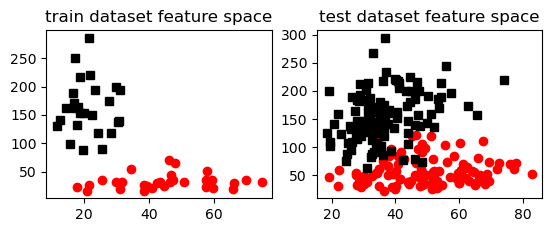

In [81]:
plt.subplot(2,2,1)
plt.plot(f_train[y_train==0,0],f_train[y_train==0,1],'or')
plt.plot(f_train[y_train==1,0],f_train[y_train==1,1],'sk')
plt.title('train dataset feature space')
plt.subplot(2,2,2)
plt.plot(f_test[y_test==0,0],f_test[y_test==0,1],'or')
plt.plot(f_test[y_test==1,0],f_test[y_test==1,1],'sk')
plt.title('test dataset feature space')
plt.show()

## **Classify data using a linear SVM**

In [82]:
model= SVC(kernel='linear',C=1000)
model.fit(f_train,y_train)
y_pred= model.predict(f_test)

## **Evaluate model**

Total Accuracy: 92.411%
Accuracy 0:     88.288%
Accuracy 1:     96.460%


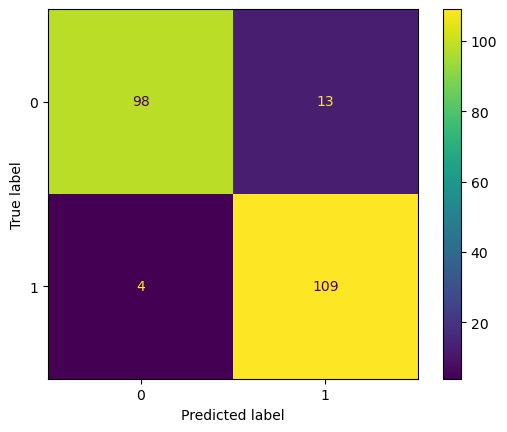

In [83]:
accuracy = metrics.accuracy_score(y_test, y_pred)
Cm= metrics.confusion_matrix(y_test,y_pred)
accuracy0= Cm[0,0]/ Cm[0,:].sum()
accuracy1= Cm[1,1]/ Cm[1,:].sum()


disp=metrics.ConfusionMatrixDisplay(Cm)
disp.plot()

print(f'Total Accuracy: {accuracy*100:.3f}%')
print(f'Accuracy 0:     {accuracy0*100:.3f}%')
print(f'Accuracy 1:     {accuracy1*100:.3f}%')
